In [2]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math
import numpy as np
# import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.mpl.ticker as cticker

from matplotlib import animation
from datetime import datetime as dt

import warnings

plt.close('all')

In [3]:
path = "H:/Summer24-25/"
file = path + "o3_Amon_CESM2-WACCM_ssp126.nc"
print(file)

H:/Summer24-25/o3_Amon_CESM2-WACCM_ssp126.nc


In [4]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ds = xr.open_dataset(file, engine="netcdf4")
ds['plev'] = ds.plev / 100
ds.plev.attrs['units'] = 'hPa'
ds.plev.attrs['requested'] = '1000. 925. 850. 700. 600. 500. 400. 300. 250. 200. 150. 100. 70. 50. 30. 20. 10. 5. 1.'
ds.plev

<xarray.DataArray 'plev' (plev: 19)> Size: 152B
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.,    5.,    1.])
Coordinates:
  * plev     (plev) float64 152B 1e+03 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0
Attributes:
    units:      hPa
    requested:  1000. 925. 850. 700. 600. 500. 400. 300. 250. 200. 150. 100. ...

# o3 by time

CPU times: total: 1min 55s
Wall time: 2min 22s


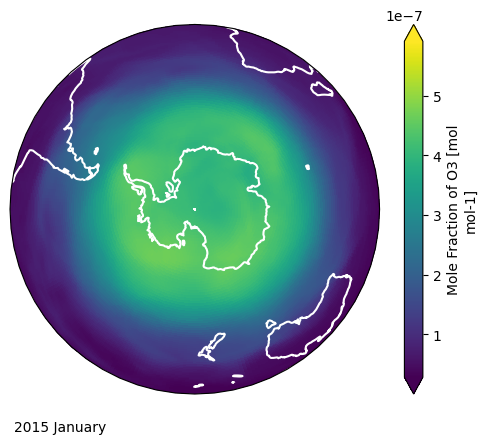

In [4]:
%%time
##un normalised colours + coasts --> GIF
pressure = 200 # req. pressure level in hPa
frames = ds.o3.time.size

fig = plt.figure()

fig.suptitle("Concentration of Mole Fraction of O3 at %shpa" %pressure)
def animate(num):
    fig.clear()
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))
    ds.o3.isel(time=num).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
    date = dt.strptime(str(ds.time[num].values), '%Y-%m-%d %H:%M:%S')
    formatted = date.strftime("%Y %B")
    ax.text(0.01, -0.1, formatted, ha='left', transform=ax.transAxes)
    ax.coastlines(color='w', lw=1.5, resolution='110m')
    ax.set_title('')
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=frames)
anim.save("o3_notNormCoasts_full.gif", writer="pillow")

CPU times: total: 1min 40s
Wall time: 2min 3s


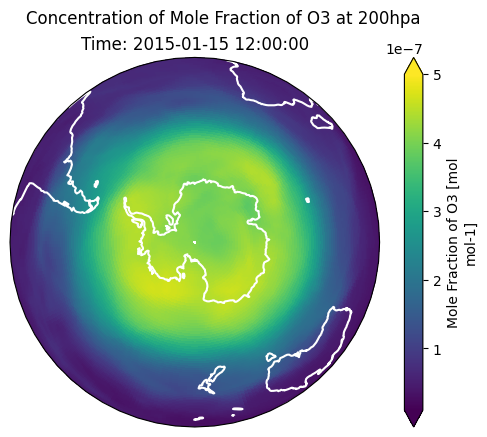

In [18]:
%%time
## normalised colours + coasts
pressure = 200 # req. pressure level in hPa
norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))
frames = ds.o3.time.size

fig = plt.figure()
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))

fig.suptitle("Concentration of Mole Fraction of O3 at %shpa" %pressure)
ds.o3.isel(time=0).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, extend='both')
def animate(num):
    ax.clear()
    ds.o3.isel(time=num).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, extend='both', add_colorbar=False)
    ax.set_title("Time: %s" %(ds.o3.isel(time=num)['time'].values))
    ax.coastlines(color='w', lw=1.5, resolution='110m')
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=frames)
anim.save("o3_normCoasts_full.gif", writer='pillow')

CPU times: total: 8min 54s
Wall time: 8min 55s


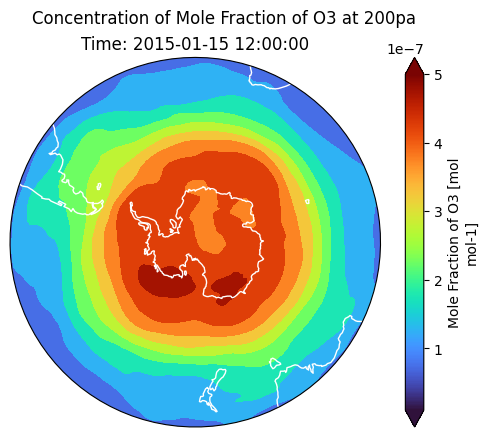

In [7]:
%%time
#contour map
pressure = 200 # req. pressure level in hPa
norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))
frames = ds.o3.time.size

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

fig = plt.figure()
ax=plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0.0))

fig.suptitle("Concentration of Mole Fraction of O3 at %shpa" %pressure)

ds.o3.isel(time=0).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='turbo', norm=norm, extend="both")

def animate(num):
    ax.clear()
    data, lons = cutil.add_cyclic_point(ds.o3.isel(time=num).sel(plev=pressure), coord=ds.lon)
    cs = ax.contourf(lons, ds.lat, data, levels=12, transform=ccrs.PlateCarree(), cmap='turbo', norm=norm, extend='both')
    ax.coastlines(color='w') # comment out to remove coastlines
    ax.set_title("Time: %s" %(ds.o3.isel(time=num)['time'].values))
    ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)


anim = animation.FuncAnimation(fig, animate, interval = 200, frames=frames)

anim.save("o3_contour_full.gif", writer='pillow')

# o3 by time, subplot by plev

CPU times: total: 3.47 s
Wall time: 4.78 s


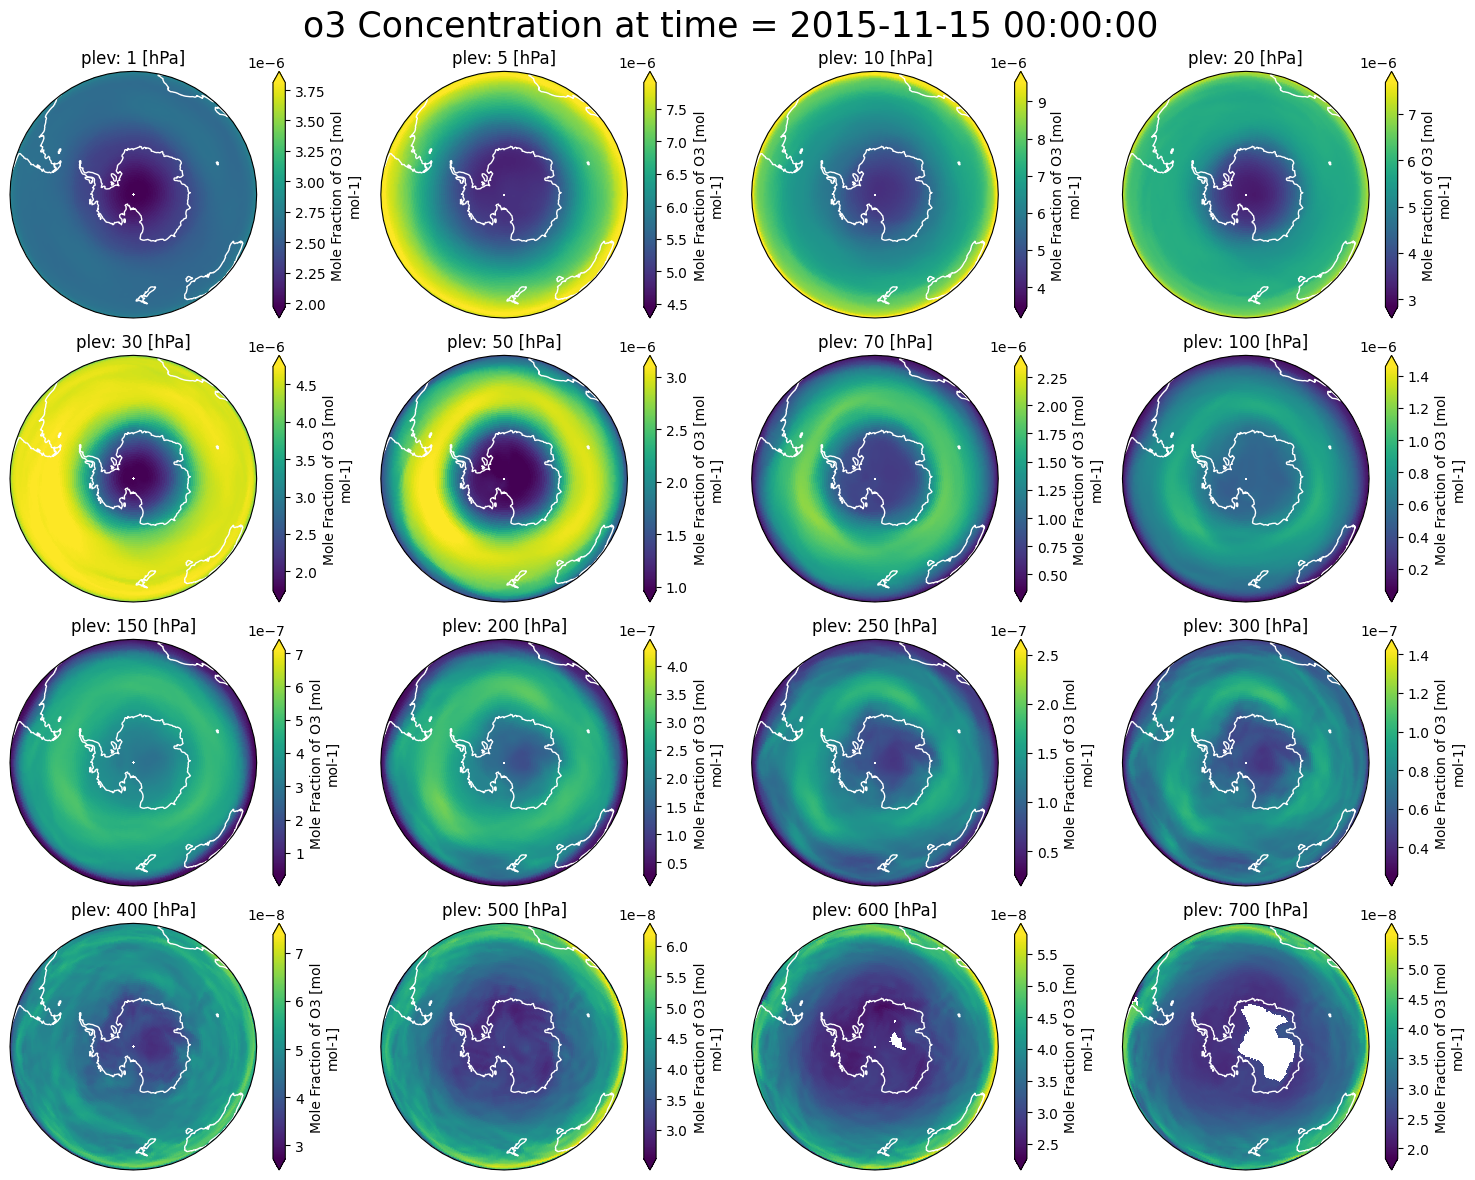

In [8]:
%%time
# at time = nTime, all plev (no anim!!!)
fig, axs = plt.subplots(4,4, figsize=(15,12), layout='tight', subplot_kw=
                        {'projection': ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=-90)})
nTime = 10

fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=nTime)['time'].values, size=25)

lev=18
for r, row in enumerate(axs):
    for c, ax in enumerate(row):
        ds.o3.isel(time=nTime, plev=lev).plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
        ax.set_title("plev: %.f [hPa]" %ds.plev.isel(plev=lev)['plev'].values)
        ax.coastlines(resolution='110m', color='w')
        lev-=1

plt.savefig("o3_byPlev.png")

CPU times: total: 3.19 s
Wall time: 3.5 s


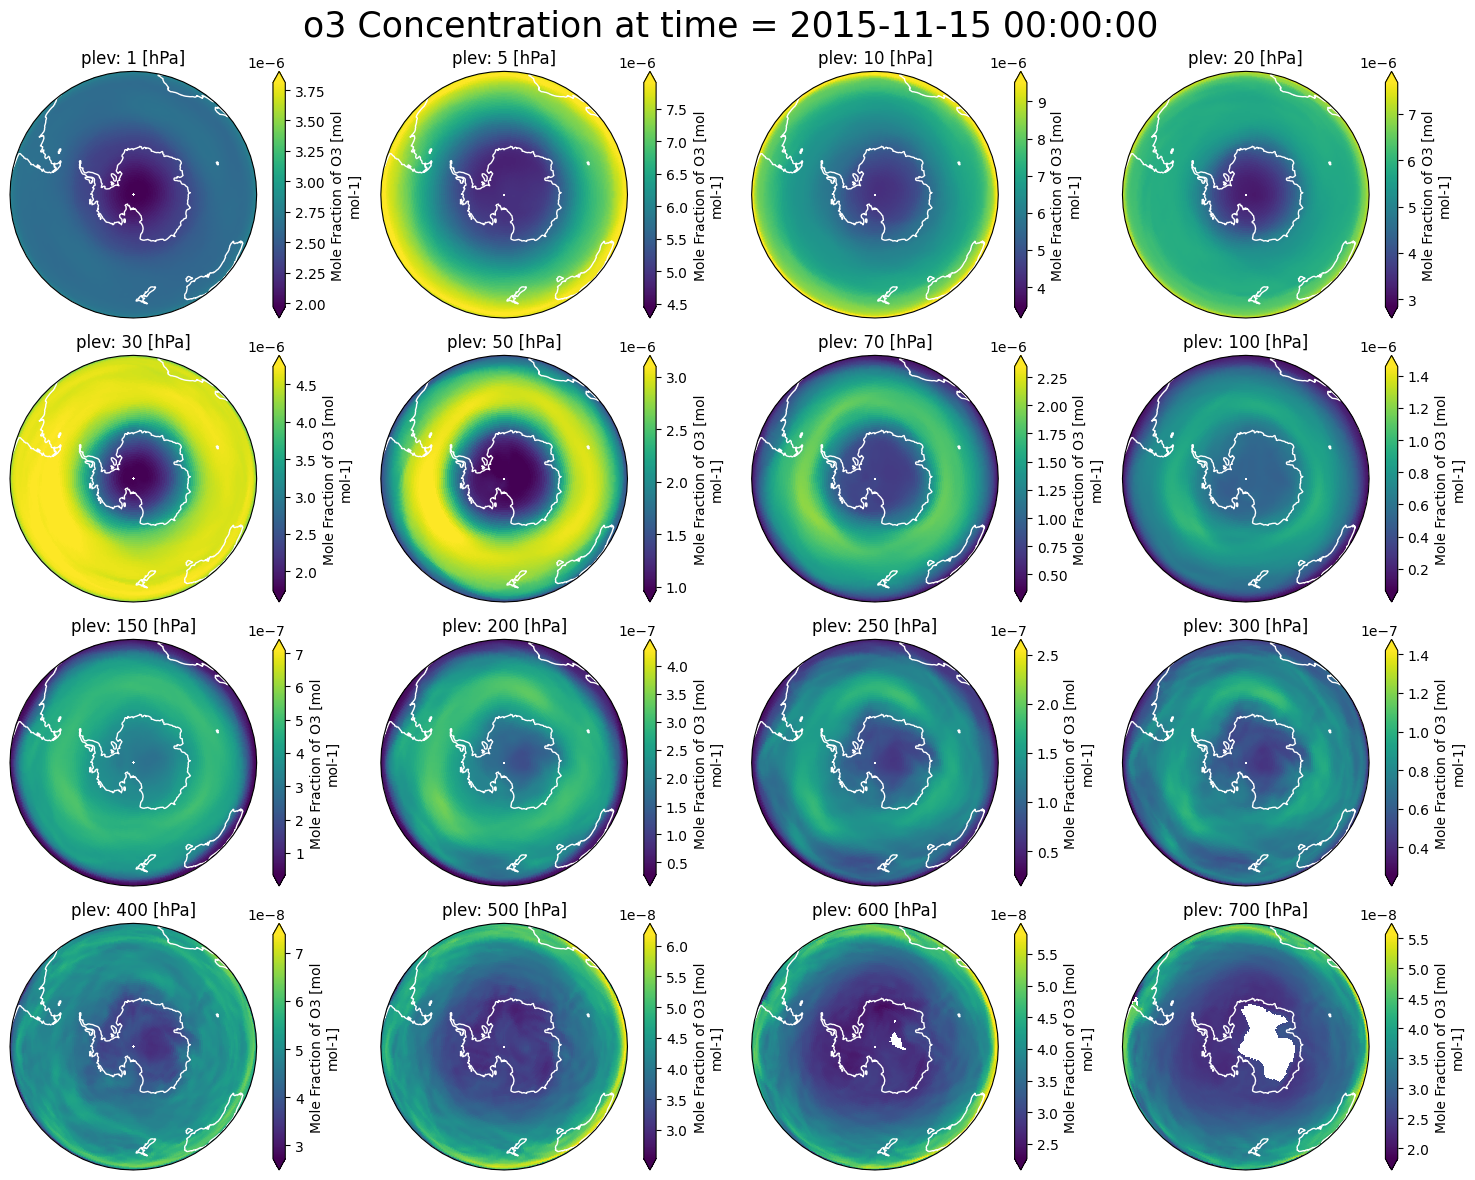

In [9]:
%%time
# at time = nTime, all plev (no anim!!!)
fig, axs = plt.subplots(4,4, figsize=(15,12), layout='tight', subplot_kw=
                        {'projection': ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=-90)})
nTime = 10

fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=nTime)['time'].values, size=25)

lev=18
for ax in axs.flat:
    ds.o3.isel(time=nTime, plev=lev).plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
    ax.set_title("plev: %.f [hPa]" %ds.plev.isel(plev=lev)['plev'].values)
    ax.coastlines(resolution='110m', color='w')
    lev-=1

plt.savefig("o3_byPlev.png")

CPU times: total: 2.7 s
Wall time: 3.42 s


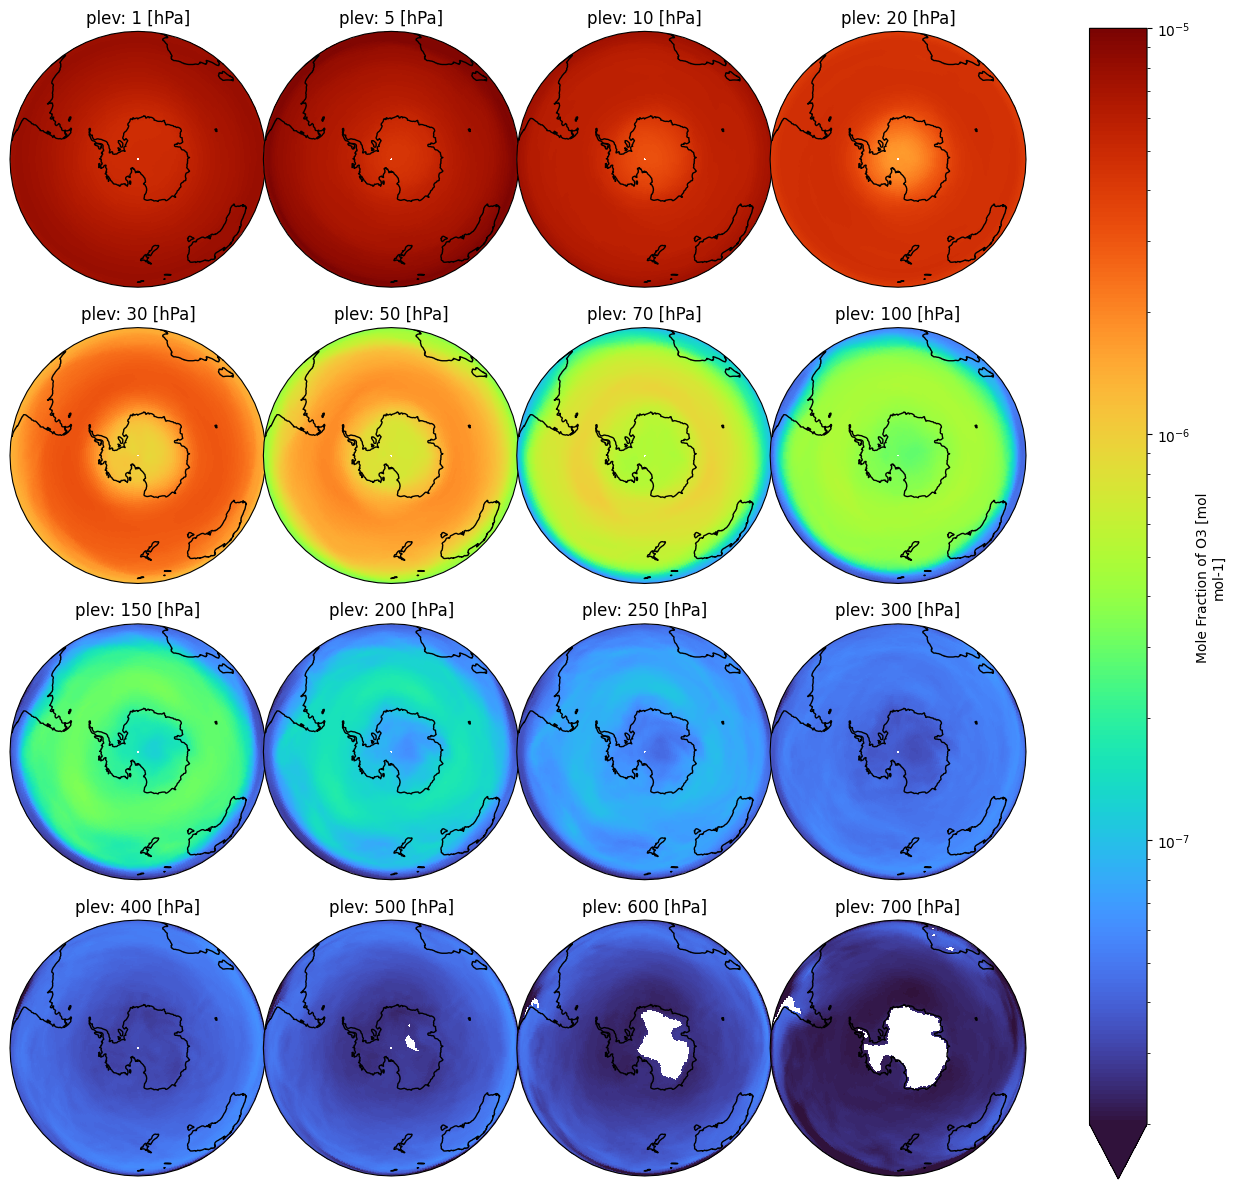

In [10]:
%%time
# # at time = nTime, facets, normalized --> cant use anim with facets
nTime = 10
fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=nTime)['time'].values, size=25)

norm = mpl.colors.LogNorm(vmin=(2*10**-8), vmax=(10**-5))
pnum = np.arange(2, 18, 1)[::-1]

p = ds.o3.isel(time=nTime).isel(plev=pnum).plot(
    transform=ccrs.PlateCarree(),
    col="plev", col_wrap=4, norm=norm, cmap='turbo', 
    subplot_kws={"projection": ccrs.Orthographic(0,-90)},
)

lev = 18
for ax in p.axs.flat:
    ax.coastlines()
    ax.set_title("plev: %.f [hPa]" %ds.plev.isel(plev=lev)['plev'].values)
    lev-=1

plt.savefig("o3_byPlev_combined.png")

CPU times: total: 3.42 s
Wall time: 4.02 s


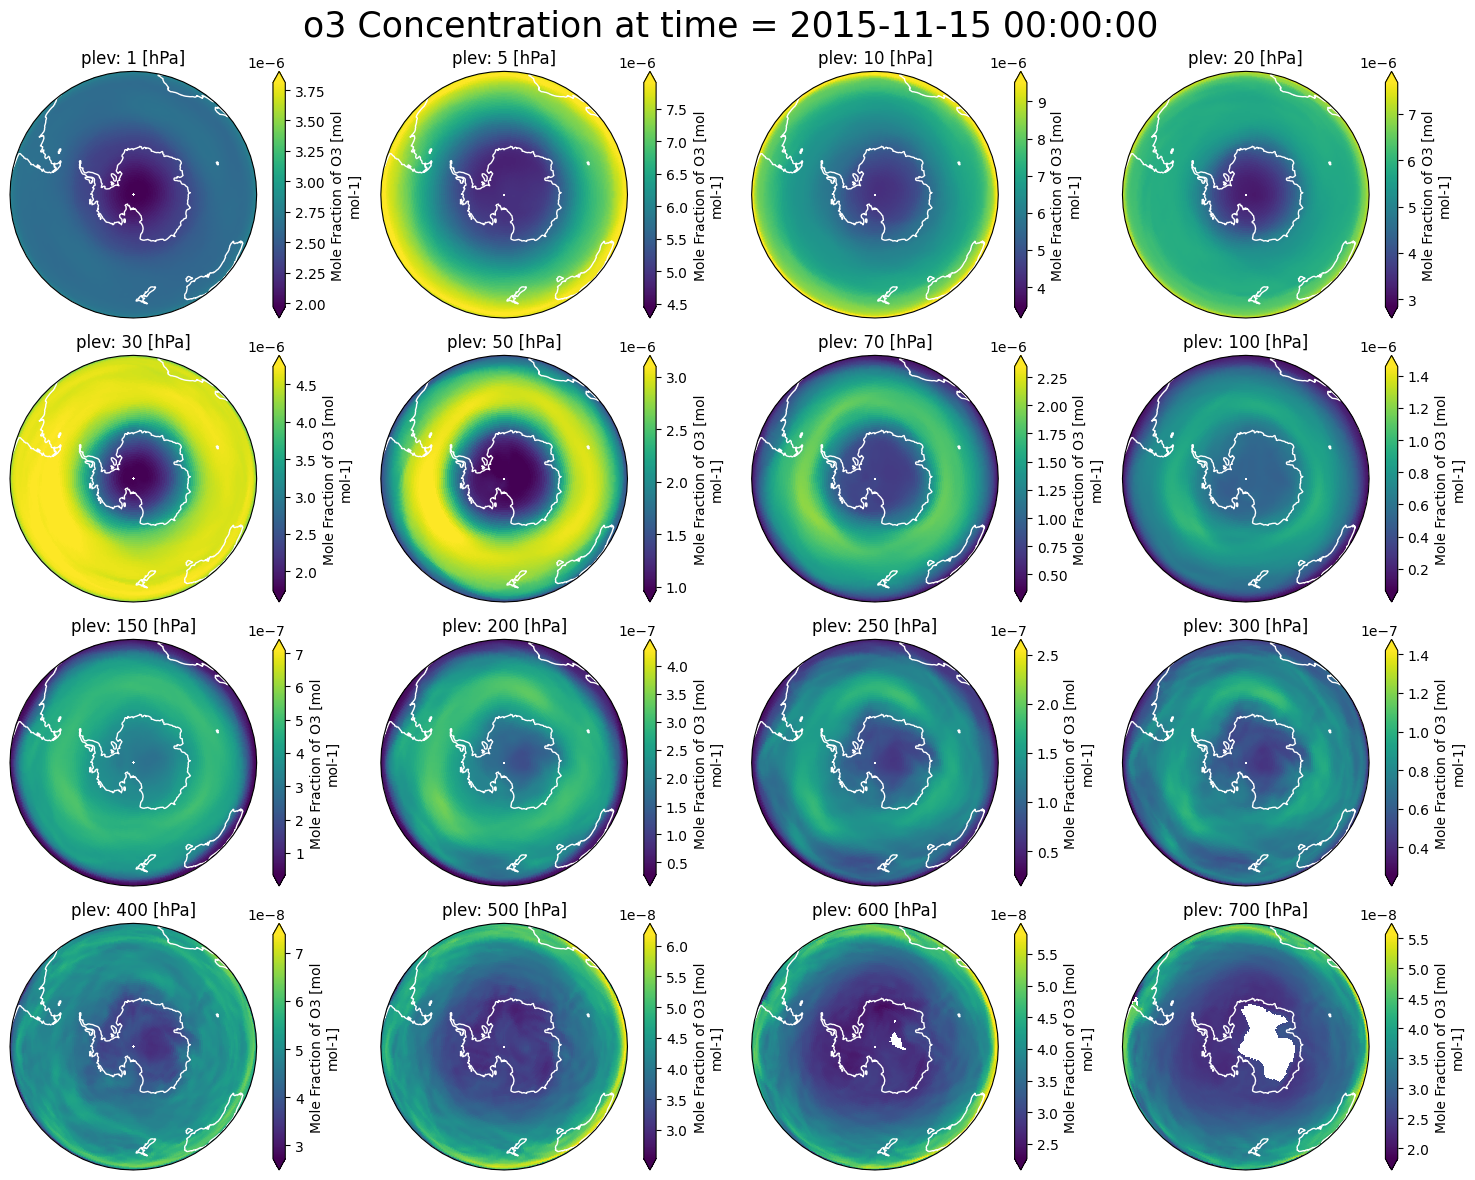

In [11]:
%%time
# at time = nTime, all plev (no anim!!!)
fig, axs = plt.subplots(4,4, figsize=(15,12), layout='tight', subplot_kw=
                        {'projection': ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=-90)})
nTime = 10

fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=nTime)['time'].values, size=25)

lev=18
for ax in axs.flat:
    ds.o3.isel(time=nTime, plev=lev).plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
    ax.set_title("plev: %.f [hPa]" %ds.plev.isel(plev=lev)['plev'].values)
    ax.coastlines(resolution='110m', color='w')
    lev-=1

plt.savefig("o3_byPlev.png")

CPU times: total: 10.8 s
Wall time: 11.1 s


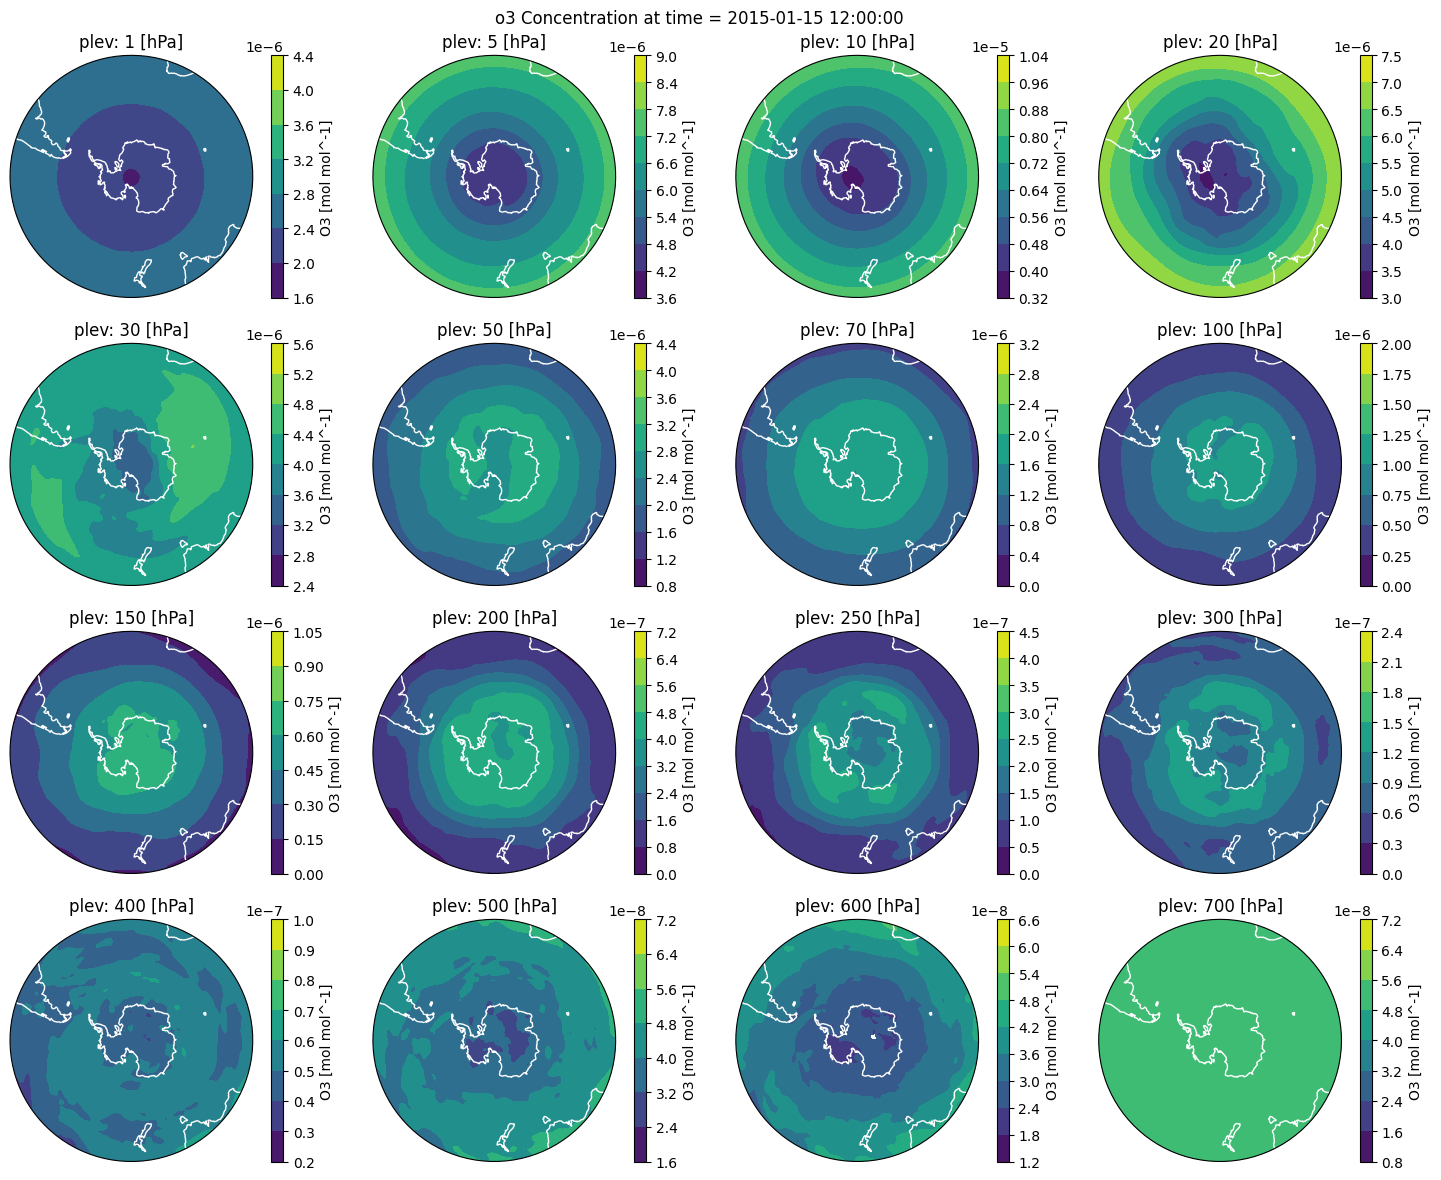

In [12]:
%%time
# at time = nTime, all plev - contour (no anim!!!)
fig, axs = plt.subplots(4,4, figsize=(15,12), layout='tight', subplot_kw=
                        {'projection': ccrs.SouthPolarStereo(central_longitude=0)})
nTime = 0

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=nTime)['time'].values)

lev=18
for ax in axs.flat:
    data, lons = cutil.add_cyclic_point(ds.o3.isel(time=nTime, plev=lev), coord=ds.lon)
    cs = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree())
    plt.colorbar(cs, label = 'O3 [mol mol^-1]')
    ax.set_title("plev: %.f [hPa]" %ds.plev.isel(plev=lev)['plev'].values)
    ax.coastlines(resolution='110m', color='w')
    ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    lev -= 1

plt.savefig("o3_byPlev_contour.png")

CPU times: total: 9min 57s
Wall time: 9min 59s


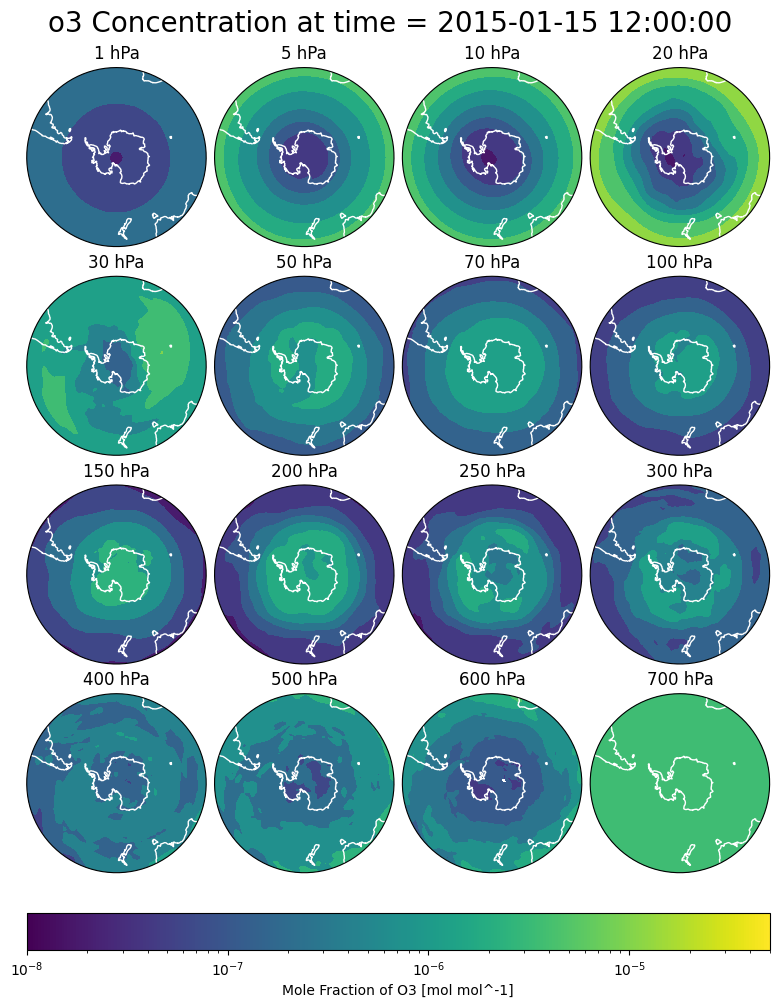

In [13]:
%%time

# all plev (color plot), animated by time
fig, axs = plt.subplots(4,4, figsize=(8,10), layout='compressed', subplot_kw=
                        {'projection': ccrs.SouthPolarStereo(central_longitude=0.0)})

frames = math.floor(ds.o3.time.size/2)
norm = mpl.colors.LogNorm(vmin=(10**-8), vmax=(5*10**-5))
cmap = 'viridis'

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location='bottom', label="Mole Fraction of O3 [mol mol^-1]")

def update(num):
    lev=18
    for ax in axs.flat:
        ax.clear()
        data, lons = cutil.add_cyclic_point(ds.o3.isel(time=num, plev=lev), coord=ds.lon)
        cs = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree(), cmap=cmap)#, norm=norm)
        ax.set_title("%.f hPa" %ds.plev.isel(plev=lev).values)
        ax.coastlines(resolution='110m', color='w')
        lev -= 1
        ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
        ax.set_boundary(circle, transform=ax.transAxes)
    fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=num).values, size=20)


anim = animation.FuncAnimation(fig=fig, func=update, frames=60, interval=200, repeat=True)

anim.save("o3_manyContour.gif", writer='pillow')

CPU times: total: 14min 33s
Wall time: 15min 37s


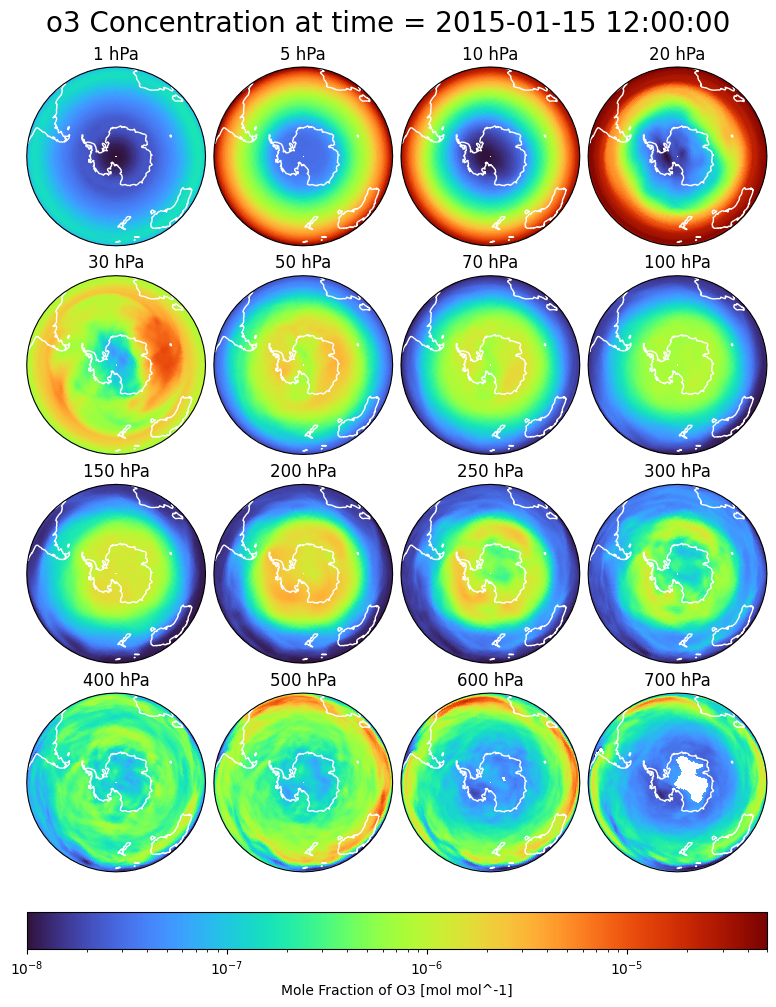

In [14]:
%%time

# at time = n, all plev (color plot), animated by time
fig, axs = plt.subplots(4,4, figsize=(8,10), layout='compressed', subplot_kw=
                        {'projection': ccrs.Orthographic(central_longitude=0.0, central_latitude=-90)})

frames = math.floor(ds.o3.time.size/2)
norm = mpl.colors.LogNorm(vmin=(10**-8), vmax=(5*10**-5))
cmap = 'turbo'

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location='bottom', label="Mole Fraction of O3 [mol mol^-1]")

def update(num):
    lev=18
    for ax in axs.flat:
        ax.clear()
        ds.o3.isel(time=num, plev=lev).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False)
        ax.set_title("%.f hPa" %ds.plev.isel(plev=lev).values)
        ax.coastlines(resolution='110m', color='w')
        lev -= 1
    fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=num).values, size=20)


anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=200, repeat=True)

anim.save("o3_subPlev_animTime.gif", writer='pillow')

# tests

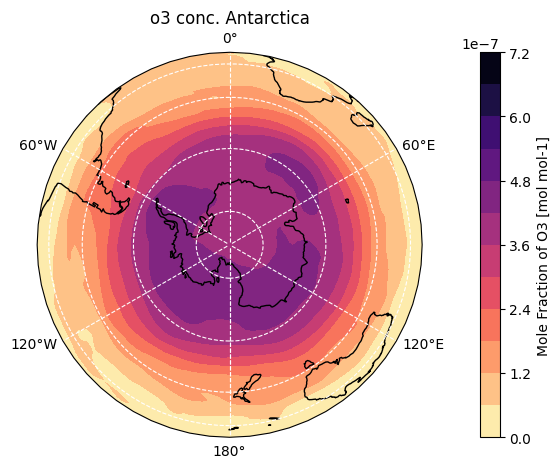

In [15]:
fig=plt.figure(figsize=[15,5])
ax=plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))

data = ds.o3.isel(time=0).sel(plev=200)
cbar_label = ds.o3.attrs['long_name'] + ' [' + ds.o3.attrs['units'] + ']'

# contour coloured map
data, lons = cutil.add_cyclic_point(data, coord=ds.lon) #else would be a white line in middle
cs = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree(), cmap='magma_r', levels=10)
plt.colorbar(cs, label = cbar_label)
# ax.set_extent([0,360, -90,-60], ccrs.PlateCarree()) #uncomment to zoom in on antarctica

ax.set_title("o3 conc. Antarctica")
ax.coastlines(color='k')
grid = ax.gridlines(ls='--', color='w', draw_labels=True)

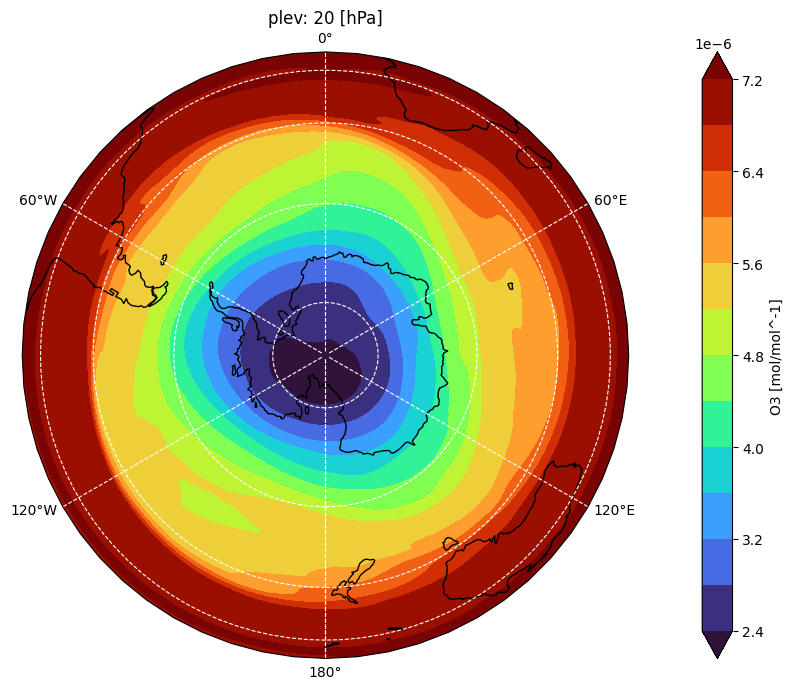

In [16]:
fig=plt.figure(figsize=(15,7), layout='tight')
ax=plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=-90))
data, lons = cutil.add_cyclic_point(ds.o3.isel(time=2, plev=15), coord=ds.lon)
cs = ax.contourf(lons, ds.lat, data, cmap='turbo', extend='both', transform=ccrs.PlateCarree(), levels=12)
plt.colorbar(cs, label = 'O3 [mol/mol^-1]')
ax.set_title("plev: %.f [hPa]" %ds.plev.isel(plev=15).values)
ax.coastlines()
ax.gridlines(draw_labels=True, ls="--", color="w")
# ax.set_extent([0,360, -90,-50], ccrs.PlateCarree()) #uncomment to zoom in on antarctica

CPU times: total: 1.08 s
Wall time: 1.09 s


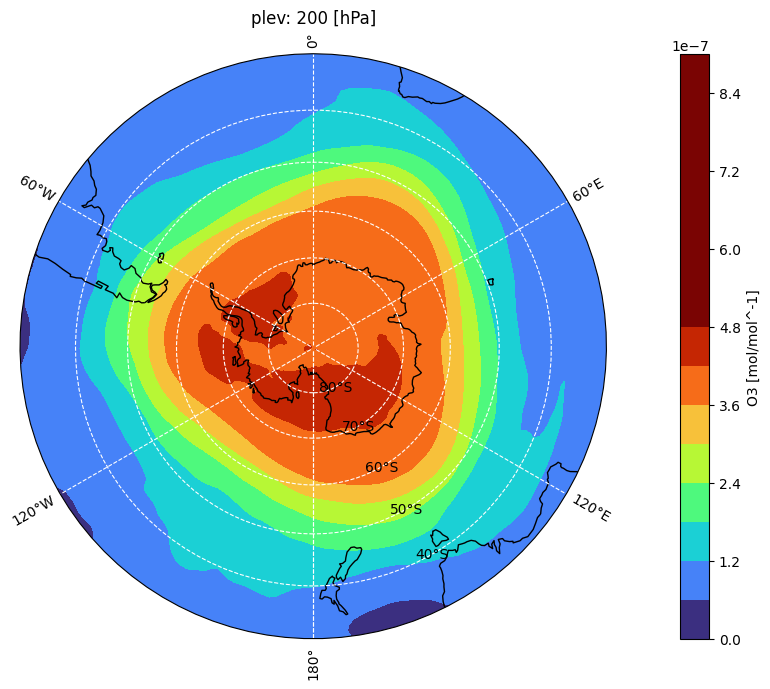

In [17]:
%%time
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))

fig=plt.figure(figsize=(15,7), layout='tight')
ax=plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0))
data, lons = cutil.add_cyclic_point(ds.o3.isel(time=2, plev=9), coord=ds.lon)
cs = ax.contourf(lons, ds.lat, data, cmap='turbo', transform=ccrs.PlateCarree(), levels=15, norm=norm)
plt.colorbar(cs, label = 'O3 [mol/mol^-1]')
ax.set_title("plev: %.f [hPa]" %ds.plev.isel(plev=9).values)
ax.coastlines()
ax.gridlines(draw_labels=True, ls="--", color="w")
ax.set_extent([0,360, -90, -30], ccrs.PlateCarree()) #uncomment to zoom in on antarctica
ax.set_boundary(circle, transform=ax.transAxes)

CPU times: total: 1.5 s
Wall time: 1.52 s


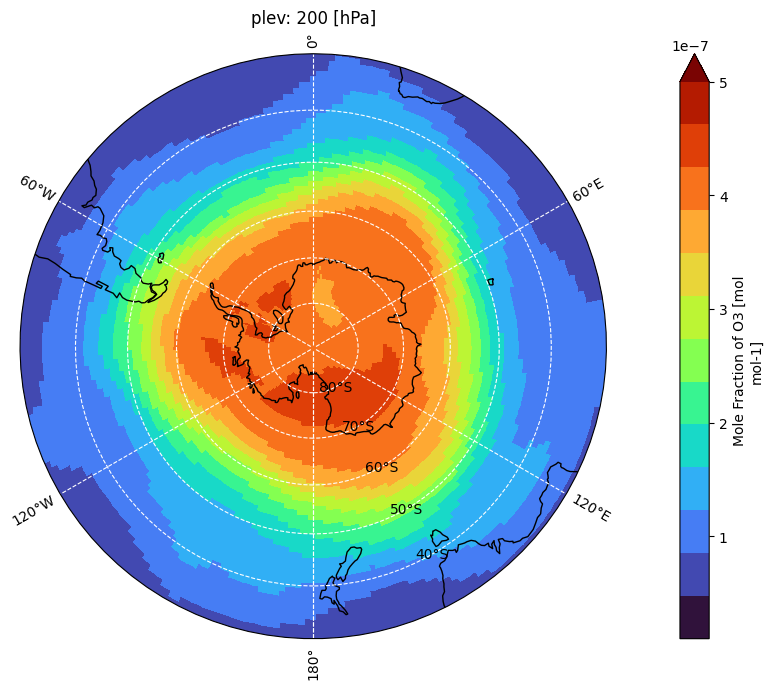

In [18]:
%%time
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))

fig=plt.figure(figsize=(15,7), layout='tight')
ax=plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0))

ds.o3.isel(time=2, plev=9).plot(ax=ax, cmap='turbo', transform=ccrs.PlateCarree(), levels=15, norm=norm)

ax.set_title("plev: %.f [hPa]" %ds.plev.isel(plev=9).values)
ax.coastlines()
ax.gridlines(draw_labels=True, ls="--", color="w")
ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

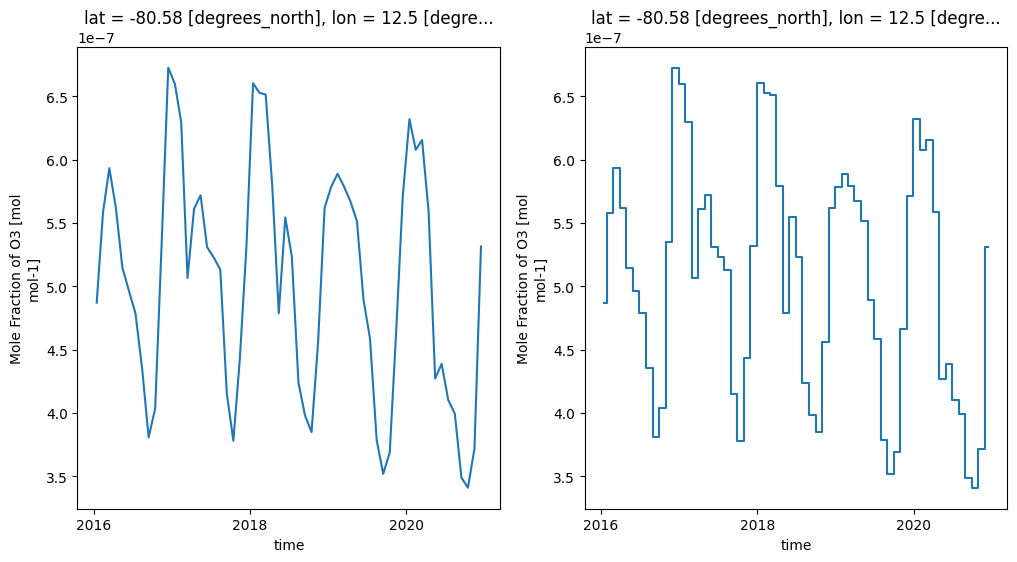

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[12,6])
o3_ds = ds.o3.isel(lat=10, lon=10, plev=10)[12:72]
o3_ds.plot.line(x='time', ax=ax1)
o3_ds.plot.step(where='mid', ax=ax2)

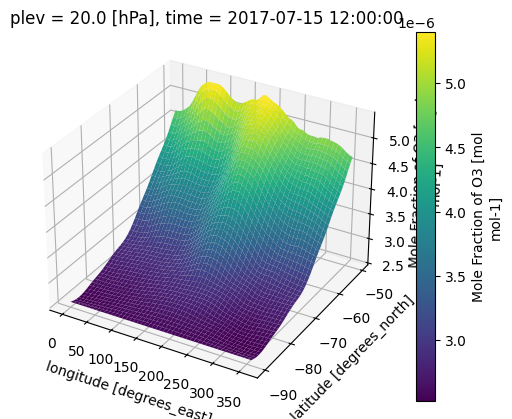

In [20]:
o3_2d = ds.o3.isel(time=30, plev=15).sel(lat=slice(-90,-50))
o3_2d.plot.surface(cmap='viridis')

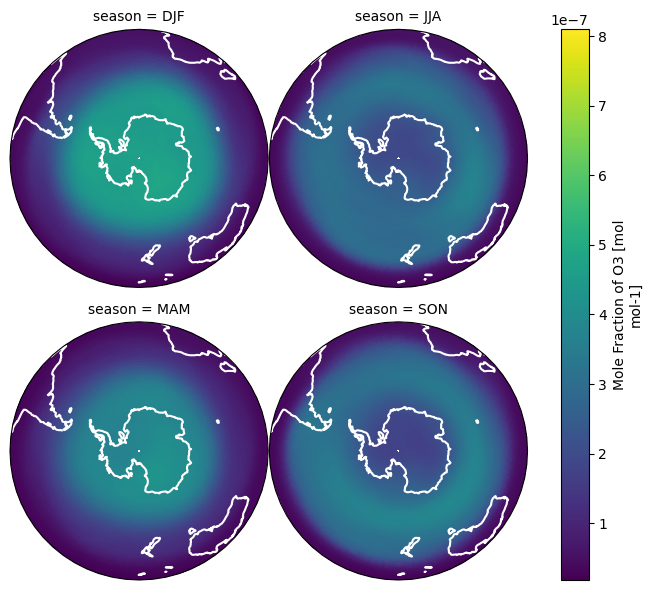

In [21]:
group = ds.o3.groupby('time.season').median(dim='time')
seasons = group.isel(plev=9).plot(col='season', col_wrap=2, transform=ccrs.PlateCarree(), subplot_kws=
                              dict(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90)))

for ax in seasons.axs.flat:
    # ax.gridlines(eg)
    # ax.set_extent((eg))
    ax.coastlines(color='w', lw=1.5, resolution='110m')
